In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Input
from tensorflow.keras.applications import ResNet50  
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [2]:
non_demented = []
very_mild_demented = []
mild_demented = []
moderate_demented = []

for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Non Demented'):
    for filename in filenames:
        non_demented.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Very mild Dementia'):
    for filename in filenames:
        very_mild_demented.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Mild Dementia'):
    for filename in filenames:
        mild_demented.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Moderate Dementia'):
    for filename in filenames:
        moderate_demented.append(os.path.join(dirname, filename))

In [3]:
images = []
labels = []
path='/kaggle/input/imagesoasis'
for subfolder in tqdm(os.listdir(path)):
    subfolder_path = os.path.join(path, subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


,image,label
0,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented
1,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented
2,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented
3,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented
4,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented
...,...,...
86432,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia
86433,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia
86434,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia
86435,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia


In [26]:
print(len(non_demented))
print(len(mild_demented))
print(len(moderate_demented))
print(len(very_mild_demented))

67222
5002
488
13725


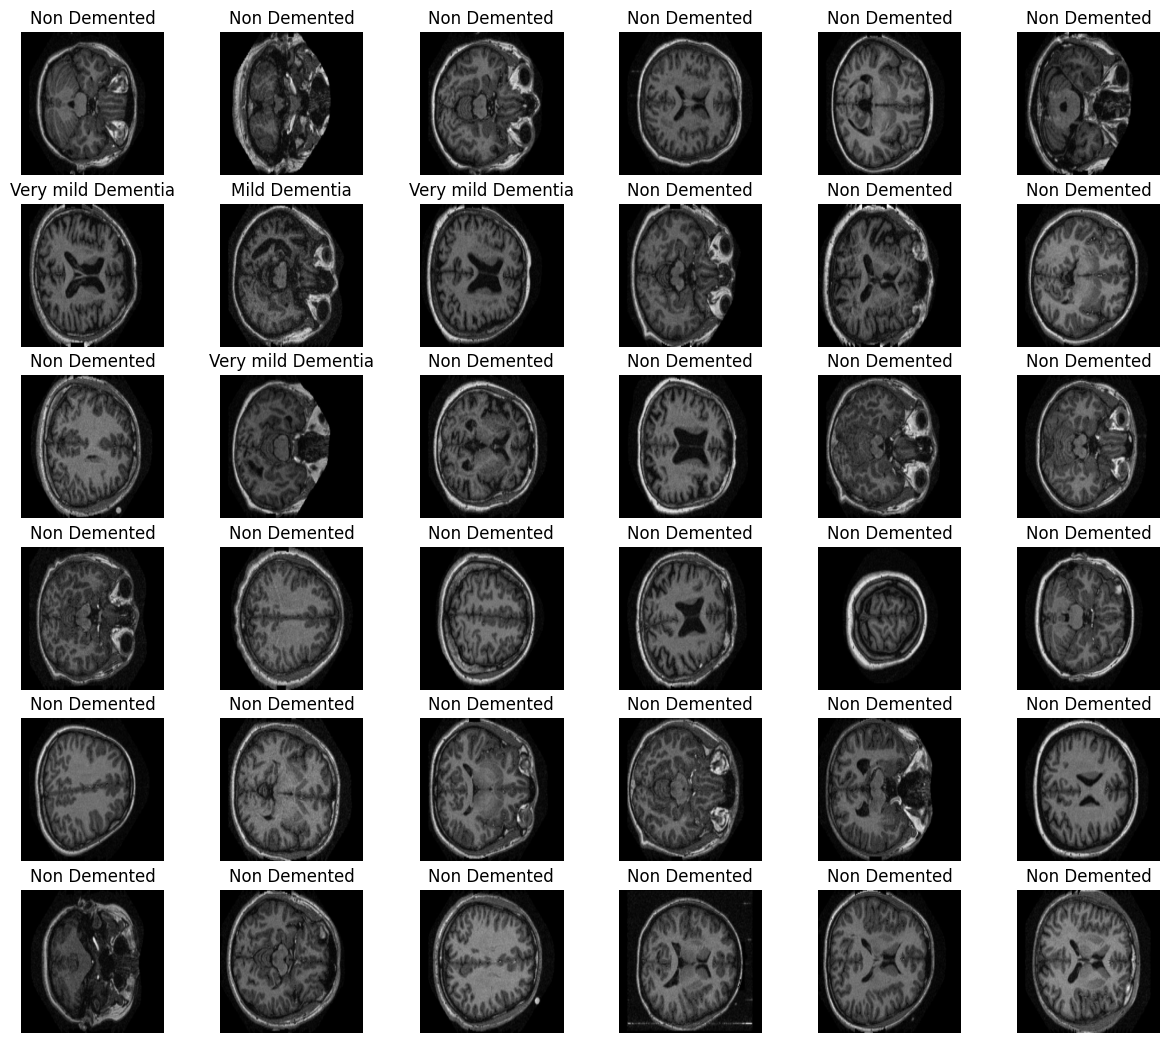

In [21]:
import random
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(15,13))
num = 36

for n, i in enumerate(random.sample(range(len(df)), num)):
    plt.subplot(6,6, n + 1)
    img = cv2.imread(df.image[i])
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i], fontsize=12)

plt.show() 

In [4]:
encoder= OneHotEncoder()
encoder.fit([[0],[1],[2],[3]])

OneHotEncoder()

In [5]:
data = []
result = []
for s in non_demented:
    img = Image.open(s)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())
        
for s in mild_demented:
    img = Image.open(s)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())
        
for s in moderate_demented:
    img = Image.open(s)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[2]]).toarray())

for s in very_mild_demented:
    img = Image.open(s)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[3]]).toarray())

In [6]:
X = np.array(data)
y = np.array(result).reshape(len(result), 4)
y = np.argmax(y, axis=1)


In [17]:
np.save('/kaggle/working/X_data_final.npy', X)
np.save('/kaggle/working/y_labels_final.npy', y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [8]:
data_augmentation = keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomTranslation(0.15, 0.15),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomContrast(0.1)
])

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D
input_tensor = Input(shape=(128, 128, 3))
augmented = data_augmentation(input_tensor)

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=augmented)


for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(4, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=x)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [23]:
print(base_model.summary())

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ sequential[0][0]  │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 15,241,216 (58.14 MB)

 Non-trainable params: 8,346,496 (31.84 MB)

None


In [10]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss', patience=7, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [ ]:
print("Phase 1: Training with frozen base model")
history_phase1 = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)



Phase 1: Training with frozen base model
Epoch 1/15
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 89s 45ms/step - accuracy: 0.6853 - loss: 0.8716 - val_accuracy: 0.7631 - val_loss: 0.5710 - learning_rate: 0.0010
Epoch 2/15
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 72s 42ms/step - accuracy: 0.7822 - loss: 0.5491 - val_accuracy: 0.7685 - val_loss: 0.5600 - learning_rate: 0.0010
Epoch 3/15
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 73s 42ms/step - accuracy: 0.7850 - loss: 0.5333 - val_accuracy: 0.7886 - val_loss: 0.5281 - learning_rate: 0.0010
Epoch 4/15
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 74s 43ms/step - accuracy: 0.7896 - loss: 0.5176 - val_accuracy: 0.7996 - val_loss: 0.4739 - learning_rate: 0.0010
Epoch 5/15
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 73s 42ms/step - accuracy: 0.7970 - loss: 0.5024 - val_accuracy: 0.8027 - val_loss: 0.4625 - learning_rate: 0.0010
Epoch 6/15
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 73s 42ms/step - accuracy: 0.7997 - loss: 0.4950 - val_accuracy: 0.8081 - val_loss: 0.4611 - learning_rate: 0.0010
Epoch 7/15
1729/1729 ━━

In [12]:
import gc
gc.collect()


752

In [ ]:
print("Phase 2: Fine-tuning the model")

for layer in base_model.layers[:int(len(base_model.layers)*0.8)]:
    layer.trainable = False
for layer in base_model.layers[int(len(base_model.layers)*0.8):]:
    layer.trainable = True


optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Phase 2: Fine-tuning the model


In [14]:
history_phase2 = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
3458/3458 ━━━━━━━━━━━━━━━━━━━━ 180s 48ms/step - accuracy: 0.7817 - loss: 0.5521 - val_accuracy: 0.7963 - val_loss: 0.4576 - learning_rate: 1.0000e-04
Epoch 2/20
3458/3458 ━━━━━━━━━━━━━━━━━━━━ 164s 47ms/step - accuracy: 0.8129 - loss: 0.4521 - val_accuracy: 0.8054 - val_loss: 0.4920 - learning_rate: 1.0000e-04
Epoch 3/20
3458/3458 ━━━━━━━━━━━━━━━━━━━━ 164s 47ms/step - accuracy: 0.8279 - loss: 0.4119 - val_accuracy: 0.8422 - val_loss: 0.3943 - learning_rate: 1.0000e-04
Epoch 4/20
3458/3458 ━━━━━━━━━━━━━━━━━━━━ 164s 47ms/step - accuracy: 0.8450 - loss: 0.3784 - val_accuracy: 0.8520 - val_loss: 0.4018 - learning_rate: 1.0000e-04
Epoch 5/20
3458/3458 ━━━━━━━━━━━━━━━━━━━━ 163s 47ms/step - accuracy: 0.8668 - loss: 0.3380 - val_accuracy: 0.8729 - val_loss: 0.3219 - learning_rate: 1.0000e-04
Epoch 6/20
3458/3458 ━━━━━━━━━━━━━━━━━━━━ 161s 47ms/step - accuracy: 0.8769 - loss: 0.3097 - val_accuracy: 0.8752 - val_loss: 0.3446 - learning_rate: 1.0000e-04
Epoch 7/20
3458/3458 ━━━━━━━━━━━━━

In [15]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy*100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

541/541 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.9551 - loss: 0.1278
Test accuracy: 95.05%
Test loss: 0.1360


In [16]:
gc.collect()


1138

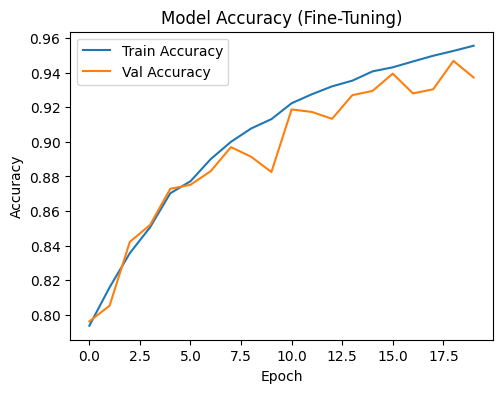

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)
plt.plot(history_phase2.history['accuracy'], label='Train Accuracy')
plt.plot(history_phase2.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy (Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


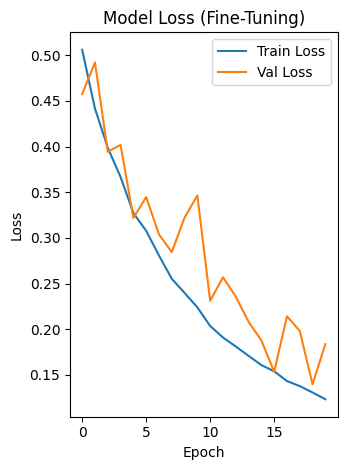

In [20]:
plt.subplot(1, 2, 2)
plt.plot(history_phase2.history['loss'], label='Train Loss')
plt.plot(history_phase2.history['val_loss'], label='Val Loss')
plt.title('Model Loss (Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
predicted_test_labels = model.predict(X_test)
res = model.predict(X_test)
predicted_test_labels =  np.argmax(predicted_test_labels,axis= 1 )
predicted_test_labels[1]
ypred = []
for i in res:
  temp = np.argmax(i)
  ypred.append(temp)
ypred = np.array(ypred)
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test,ypred))

print(classification_report(y_test,ypred))
print(confusion_matrix(y_test,ypred))

541/541 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step
541/541 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step
0.9505437297547432
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     13445
           1       0.94      0.90      0.92      1000
           2       0.86      0.99      0.92        98
           3       0.88      0.84      0.86      2745

    accuracy                           0.95     17288
   macro avg       0.91      0.93      0.92     17288
weighted avg       0.95      0.95      0.95     17288

[[13117    38     9   281]
 [   68   903     7    22]
 [    1     0    97     0]
 [  405    24     0  2316]]


541/541 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step


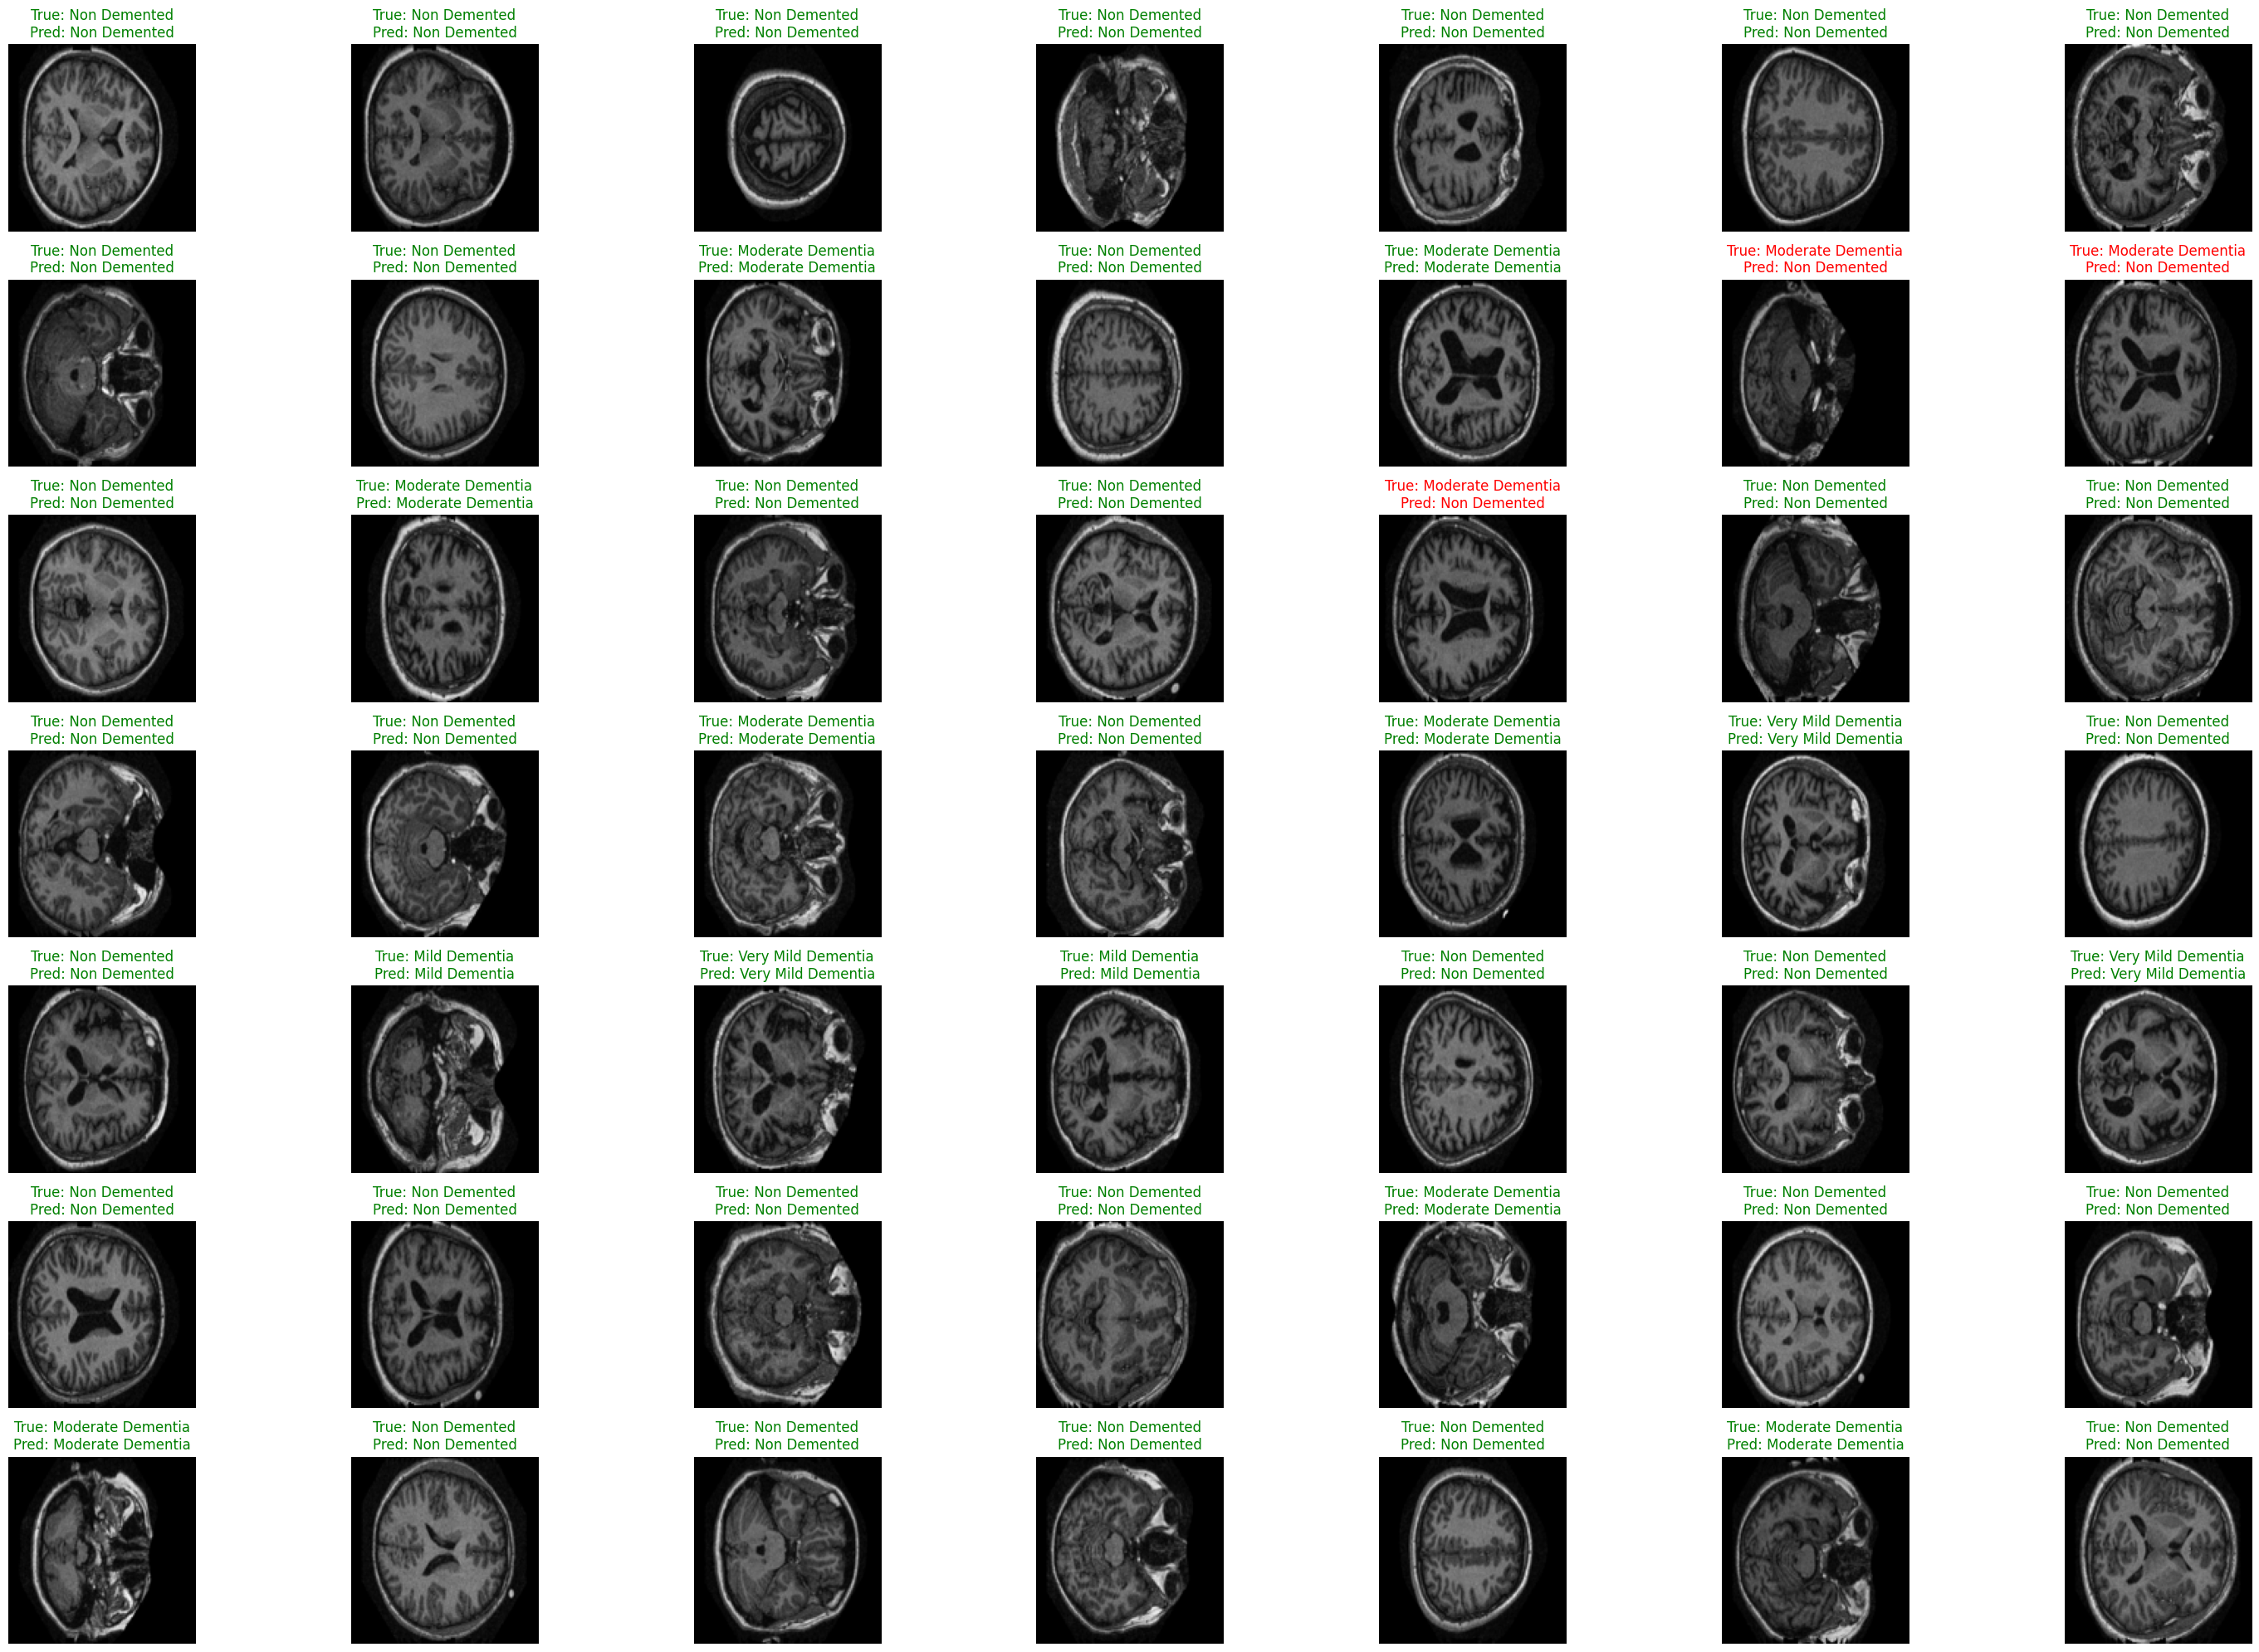

In [25]:
import numpy as np
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1) 

class_names = [
    "Non Demented",         
    "Very Mild Dementia",   
    "Mild Dementia",        
    "Moderate Dementia"     
]

num_images = 49
indices = np.random.choice(len(X_test), num_images, replace=False)

plt.figure(figsize=(30,20))

for i, idx in enumerate(indices):
    plt.subplot(7, 7, i + 1)  
    plt.imshow(X_test[idx], cmap='gray')
    
    # Set color: green if correct, red if incorrect
    color = 'green' if y_test[idx] == y_pred[idx] else 'red'
    
    plt.title(f'True: {class_names[y_test[idx]]}\nPred: {class_names[y_pred[idx]]}', color=color)
    plt.axis('off')  

plt.tight_layout()
plt.show()


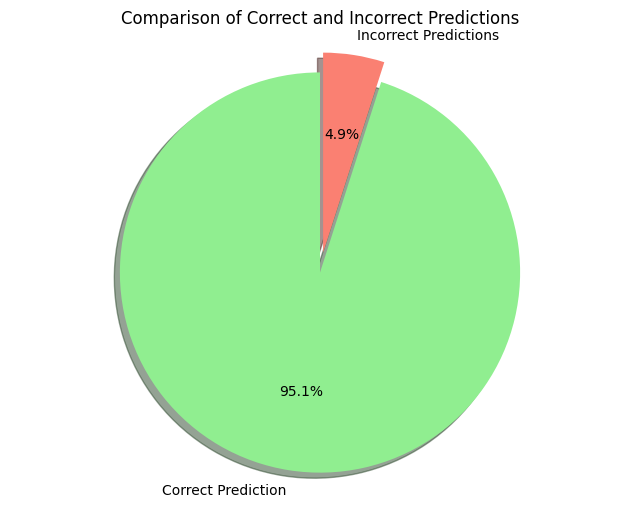

In [27]:
import numpy as np
import matplotlib.pyplot as plt


correct_predictions = np.sum(y_test == y_pred)
incorrect_predictions = np.sum(y_test != y_pred)

labels = ['Correct Prediction', 'Incorrect Predictions']
sizes = [correct_predictions, incorrect_predictions]
colors = ['lightgreen', 'salmon']
explode = (0.1, 0)  

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')  
plt.title('Comparison of Correct and Incorrect Predictions')
plt.show()

In [28]:
sizes = [correct_predictions, incorrect_predictions]
print("Number of Correct Predictions : ",correct_predictions)
print("Number of Incorrect Predictions : ",incorrect_predictions)

Number of Correct Predictions :  16433
Number of Incorrect Predictions :  855
